In [1]:
import numpy as np
import pandas as pd

import os
import time 

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import pydot

In [2]:
import pickle

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
def mkdir(name):
    try:
        os.mkdir(name)
    except:
        print('Directory exists')
        
mkdir('PlasmaDon_questionnaires')

Directory exists


In [5]:
N_SAMPLES = 200

### Define functions

In [6]:
def validate_data(data):
    
    # adjust hidden answers to defaults:
    data.loc[ data.generally_ill == 1, 'illness_level' ] = -1
    data.loc[ data.work_env == 3     , ['work_protec', 'work_exposure'] ] = -1
    data.loc[ data.date_symptoms == 2, 'date_symptoms' ] = -1
    
    # illogical data
    return data[ np.logical_not( (data.generally_ill == 1) & ((data.sympt_fever == 0) | (data.sympt_sens_fev == 0)) )]

In [7]:
def prepare_features( data, features, label = None ):
    
    x = data[ftrs]
    
    if label is not None:
        y = data[label]
    else:
        y = None

    return x, y

In [8]:
def train_test_RF( x, y, hyperparams, test_size ):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    
    RF = RandomForestClassifier( **hyperparams, oob_score = True, n_jobs = -1)
    
    tt = time.time()
    RF.fit( x_train, y_train )
    y_pred = RF.predict( x_test )
    print('Training and testing %.2fs' %(time.time()-tt))
    
    return y_test, y_pred

In [9]:
def crossval_RF( x, y, hyperparams, cv ):
    
    RF = RandomForestClassifier( **hyperparams, oob_score = True, n_jobs = -1)
    
    tt = time.time()
    y_cv = cross_val_predict( RF, x, y, cv = 5, n_jobs = -1 )
    print('%d-fold cross-validation in %.2fs' %(cv, time.time()-tt))
    
    return y, y_cv

In [10]:
def fit_RF( x, y, hyperparams ):
    
    tt = time.time()
    RF = RandomForestClassifier( **hyperparams, oob_score = True, n_jobs = -1)
    RF.fit( x, y )
    print('Fitted RF in %.2fs' %(time.time()-tt))
    
    return RF

In [11]:
def eval_prediciton( y_true, y_pred, labels, label_dict ):
    labelname = [ label_dict[i] for i in labels ]
    
    print( pd.DataFrame( confusion_matrix(y_true, y_pred, labels = [1, 2, 3, 4]), 
                         columns = labelname, index = labelname ) )
    print('\n')
    print('Accuracy:  %.3f' %accuracy_score (y_true, y_pred))
    print('Precision: %.3f' %precision_score(y_true, y_pred, average = 'macro'))
    print('Recall:    %.3f' %recall_score   (y_true, y_pred, average = 'macro'))
    print('F1 score:  %.3f' %f1_score       (y_true, y_pred, average = 'macro'))

In [12]:
def plot_feature_importance( rf, feature_names, show_std = False ):
    
    n_features = len(feature_names)
    importance = np.mean([tree.feature_importances_ for tree in rf.estimators_],axis=0)
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
    ind = np.argsort(importance)[-n_features:]
    
    if show_std:
        std_err = std[ind]
    else:
        std_err = None
    
    plt.figure()
    ax = plt.axes()
    plt.barh(range(n_features),importance[ind],
           color="r", xerr=std_err, alpha=0.4, align="center")
    plt.yticks(range(n_features), feature_names[ind])
    plt.ylim([-1, len(ind)])

    # pos : [left, bottom, width, height]
    ax.set_position( [0.3, 0.11, 0.68, 0.77] )

# MODEL DATA

In [13]:
# Load data
SAMPLES0 = pd.read_csv('PlasmaDon_questionnaires/answers_nonuniform_%d.csv' %(N_SAMPLES), index_col = 0)
SAMPLES1 = pd.read_csv('PlasmaDon_questionnaires/answers_nonuniform_%d_V1.csv' %(N_SAMPLES), index_col = 0)
SAMPLES2 = pd.read_csv('PlasmaDon_questionnaires/answers_nonuniform_%d_V2.csv' %(120), index_col = 0)

# Load data
LABELS0 = pd.read_csv('PlasmaDon_questionnaires/labels_nonuniform_%d.csv' %(N_SAMPLES), index_col = 0)
LABELS1 = pd.read_csv('PlasmaDon_questionnaires/labels_nonuniform_%d_V1.csv' %(N_SAMPLES), index_col = 0)
LABELS2 = pd.read_csv('PlasmaDon_questionnaires/labels_nonuniform_%d_V2.csv' %(120), index_col = 0)

In [14]:
SAMPLES0['label'] = LABELS0
SAMPLES1['label'] = LABELS1
SAMPLES2['label'] = LABELS2

In [15]:
data_all = pd.concat([SAMPLES0, SAMPLES1, SAMPLES2]).dropna()
data_wo_labels = pd.concat([SAMPLES0[SAMPLES0.label.isna()], 
                            SAMPLES1[SAMPLES1.label.isna()], SAMPLES2[SAMPLES2.label.isna()]]).drop('label', axis = 1)

In [16]:
label_dict = { 1 : 'Very unlikely',
               2 : 'Unlikely' , 
               3 : 'Likely', 
               4 : 'Very likely' }

In [17]:
data_all.reset_index().pivot(columns = 'label', values = 'label').describe().iloc[0] / len(data_all)

label
1.0    0.105
2.0    0.275
3.0    0.385
4.0    0.235
Name: count, dtype: float64

### Split training and test set

In [18]:
ftrs = data_all.columns[2:-1]
lbl  = data_all.columns[-1]

In [19]:
# train classifier
x, y = prepare_features(data_all, ftrs, lbl)

In [20]:
RF_params = {'n_estimators': 200,
             'min_samples_split': 10,
             'min_samples_leaf': 1,
             'max_features': 6,
             'max_depth': 15}

In [21]:
y_true, y_pred = crossval_RF(x, y, RF_params, cv = 5)
eval_prediciton( y_true, y_pred, labels = [1, 2, 3, 4], label_dict = label_dict )

5-fold cross-validation in 3.07s
               Very unlikely  Unlikely  Likely  Very likely
Very unlikely              1        12       7            1
Unlikely                   2        24      25            4
Likely                     0        18      50            9
Very likely                1         3      22           21


Accuracy:  0.480
Precision: 0.438
Recall:    0.395
F1 score:  0.393


In [22]:
data_all.shape

(200, 19)

## Grid search

In [ ]:
# Number of trees in random forest
n_estimators = [200, 500]
# Number of features to consider at every split
max_features = [1, 2, 4, 8, 12, 16]
# Maximum number of levels in tree
max_depth = [ 3, 5, 10, 15, 20 ]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]

# Create the random grid
grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf }
print(grid)

rf  = RandomForestClassifier()
clf = RandomizedSearchCV(rf, grid, scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], 
                   refit = 'accuracy', n_jobs = -1, n_iter = 200)

tt = time.time()
clf.fit(x, y)
print(time.time()-tt)

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

### Evaluate on test set

In [24]:
train, test = train_test_split(validate_data(data_all), test_size = 0.25)
x_test, y_test = prepare_features(test, ftrs, lbl)

In [25]:
RF     = fit_RF( x, y, RF_params )
y_pred = RF.predict( x_test )

eval_prediciton( y_test, y_pred, labels = [1, 2, 3, 4], label_dict = label_dict )

Fitted RF in 0.46s
               Very unlikely  Unlikely  Likely  Very likely
Very unlikely              1         1       0            0
Unlikely                   1        11       1            0
Likely                     0         2      10            1
Very likely                0         0       2            5


Accuracy:  0.771
Precision: 0.722
Recall:    0.707
F1 score:  0.713


<IPython.core.display.Javascript object>


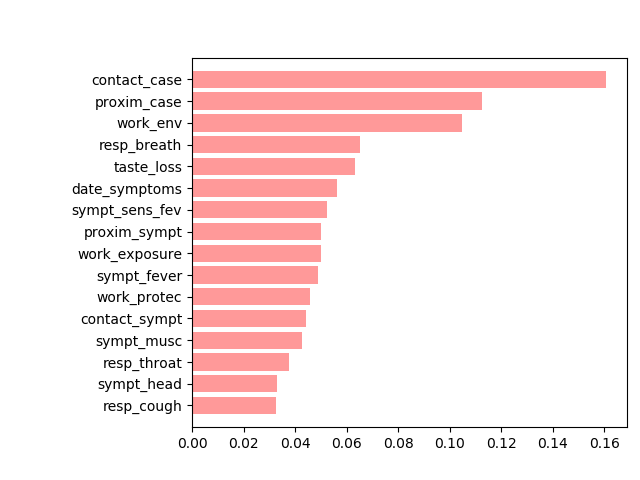

In [26]:
plot_feature_importance(RF, ftrs, show_std = False)

### Save model

In [27]:
filename = 'RF_model_trained.sav'
pickle.dump(RF, open(filename, 'wb'))

In [28]:
export_graphviz(RF.estimators_[0], out_file = 'tree_0.dot', 
                feature_names = ftrs, rounded = True, precision = 1)

In [29]:
(graph, ) = pydot.graph_from_dot_file('tree_0.dot')

In [30]:
graph.write_png('tree_0.png');

## Assess distribution of class probabilities for each class

In [31]:
train_probas = pd.DataFrame(RF.predict_proba(x), columns = ['p1', 'p2', 'p3', 'p4'])

In [32]:
train_probas['label'] = RF.predict(x)

In [33]:
train_probas.pivot(columns = 'label', values = 'p1').describe()

label,1.0,2.0,3.0,4.0
count,11.000000,56.000000,90.000000,43.000000
mean,0.391754,0.138215,0.082642,0.037481
std,0.051185,0.078434,0.074365,0.029725
min,0.308997,0.040139,0.005854,0.004262
25%,0.357959,0.079286,0.029371,0.017348
50%,0.400829,0.112559,0.061347,0.030953
75%,0.429748,0.192308,0.105930,0.044089
max,0.461442,0.313326,0.325413,0.155349


In [34]:
train_probas.pivot(columns = 'label', values = 'p2').describe()

label,1.0,2.0,3.0,4.0
count,11.000000,56.000000,90.000000,43.000000
mean,0.339443,0.500796,0.202441,0.127118
std,0.061824,0.096693,0.094235,0.056246
min,0.241185,0.306181,0.043264,0.059760
25%,0.308347,0.443935,0.121458,0.087310
50%,0.322713,0.491422,0.198956,0.116538
75%,0.391670,0.531335,0.281141,0.155740
max,0.423465,0.744597,0.424390,0.292878


In [35]:
train_probas.pivot(columns = 'label', values = 'p3').describe()

label,1.0,2.0,3.0,4.0
count,11.000000,56.000000,90.000000,43.000000
mean,0.161545,0.274639,0.540257,0.258583
std,0.094959,0.082588,0.101275,0.094228
min,0.061052,0.105195,0.334230,0.076926
25%,0.074848,0.198134,0.469227,0.183088
50%,0.117044,0.285553,0.551108,0.243267
75%,0.237067,0.331246,0.612543,0.323775
max,0.299630,0.430282,0.740968,0.446755


In [36]:
train_probas.pivot(columns = 'label', values = 'p4').describe()

label,1.0,2.0,3.0,4.0
count,11.000000,56.000000,90.000000,43.000000
mean,0.107258,0.086350,0.174659,0.576817
std,0.042883,0.041283,0.101452,0.088361
min,0.043366,0.025766,0.042522,0.393528
25%,0.085735,0.056613,0.095773,0.504806
50%,0.091079,0.077212,0.141034,0.590163
75%,0.137469,0.106119,0.241265,0.648339
max,0.179855,0.233800,0.456280,0.734320


### Define scoring function

In [37]:
def score_to_percentage(score, probabilities = None):
    p0    = [20, 40, 60, 80]
    p_cls = [35, 50, 55, 60]
    
    if probabilities is None:
        return score * 20
    
    cls_idx = int(score) - 1
    highest_proba = probabilities[cls_idx] * 100
    cls_2nd = np.argsort(probabilities)[-2]
    
    if highest_proba >= p_cls[cls_idx]:
        return p0[cls_idx]
    
    else:
        return (p0[cls_idx] + p0[cls_2nd]) / 2

#### Test example

In [38]:
test_sample = {
    'generally_ill' : 1, # Q1
    'illness_level' : 0, # NEW
    'resp_cough'    : 0, # Q2.1
    'resp_throat'   : 0, # Q2.2
    'resp_breath'   : 0, # Q2.3
    'taste_loss'    : 0, # Q3
    'sympt_fever'   : 1, # Q4.1
    'sympt_sens_fev': 1, # Q4.2
    'sympt_musc'    : 1, # Q4.3
    'sympt_head'    : 1, # Q4.4
    'date_symptoms' : 1, # Q5
    'work_env'      : 1, # Q6
    'work_protec'   : 0, # Q7.a
    'work_exposure' : 1, # Q7.b
    'proxim_sympt'  : 1, # Q8.1
    'proxim_case'   : 1, # Q8.2
    'contact_sympt' : 1, # Q9.1
    'contact_case'  : 1, # Q9.2
}  

In [47]:
probabilities = RF.predict_proba( pd.Series(test_sample).values.reshape(1, -1)[:,2:] )
score         = RF.predict( pd.Series(test_sample).values.reshape(1, -1)[:,2:] )

In [48]:
score_to_percentage(score[0], probabilities[0])

60

## Evaluate test set

In [49]:
test['prediction'] = y_pred

In [50]:
test_pred_proba = RF.predict_proba(x_test)

In [51]:
test['predicted_percentage'] = [score_to_percentage(y_pred[i], test_pred_proba[i]) for i in range(len(y_pred))]

In [52]:
test['p1'] = test_pred_proba[:,0]
test['p2'] = test_pred_proba[:,1]
test['p3'] = test_pred_proba[:,2]
test['p4'] = test_pred_proba[:,3]

In [53]:
test[abs(test.prediction - test.label) > 1]

,generally_ill,illness_level,resp_cough,resp_throat,resp_breath,taste_loss,sympt_fever,sympt_sens_fev,sympt_musc,sympt_head,...,proxim_case,contact_sympt,contact_case,label,prediction,predicted_percentage,p1,p2,p3,p4
25,1,-1,1,1,0,1,1,1,1,0,...,1,1,1,1.0,3.0,50.0,0.239262,0.265045,0.374480,0.121213
2,1,-1,0,0,1,1,1,1,1,1,...,1,1,1,4.0,1.0,20.0,0.385794,0.317307,0.117044,0.179855
12,0,4,1,0,0,0,0,0,0,0,...,1,1,0,2.0,4.0,60.0,0.027725,0.257315,0.124797,0.590163
63,0,4,1,0,0,1,1,1,1,0,...,1,1,1,1.0,3.0,40.0,0.229030,0.206879,0.424395,0.139696


In [54]:
test

,generally_ill,illness_level,resp_cough,resp_throat,resp_breath,taste_loss,sympt_fever,sympt_sens_fev,sympt_musc,sympt_head,...,proxim_case,contact_sympt,contact_case,label,prediction,predicted_percentage,p1,p2,p3,p4
3,0,2,1,1,1,1,1,0,1,0,...,0,1,1,4.0,4.0,70.0,0.025775,0.068686,0.446755,0.458785
57,0,1,1,1,0,1,0,1,1,1,...,1,1,1,3.0,3.0,50.0,0.092491,0.313537,0.455779,0.138193
21,0,1,0,1,0,0,1,1,0,1,...,1,1,1,3.0,3.0,60.0,0.039370,0.179044,0.714833,0.066754
29,0,3,0,1,1,1,0,1,1,1,...,1,1,1,2.0,2.0,40.0,0.145339,0.550594,0.212648,0.091419
25,1,-1,1,1,0,1,1,1,1,0,...,1,1,1,1.0,3.0,50.0,0.239262,0.265045,0.374480,0.121213
2,1,-1,0,0,1,1,1,1,1,1,...,1,1,1,4.0,1.0,20.0,0.385794,0.317307,0.117044,0.179855
52,0,4,0,1,0,1,0,1,1,0,...,0,0,1,3.0,3.0,60.0,0.017202,0.158883,0.638001,0.185914
0,0,3,1,1,1,1,0,1,1,0,...,1,1,0,4.0,4.0,70.0,0.036450,0.164526,0.248995,0.550029
32,0,4,1,0,1,0,0,1,0,1,...,0,1,0,4.0,4.0,70.0,0.019998,0.111936,0.375991,0.492075
29,0,0,0,1,1,0,0,0,1,1,...,1,1,1,3.0,2.0,40.0,0.077105,0.561658,0.280557,0.080680


<IPython.core.display.Javascript object>


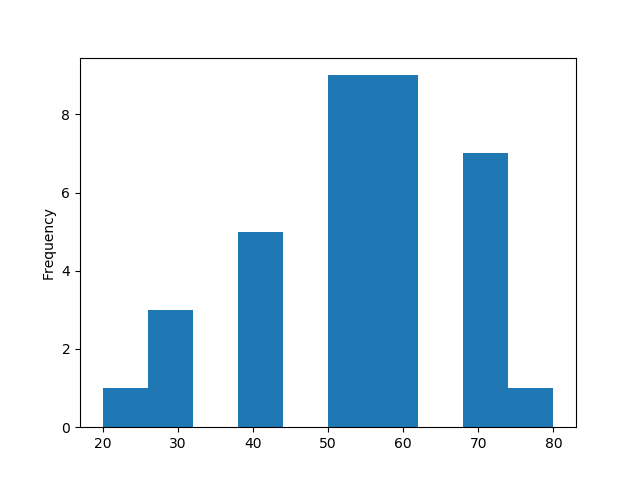

In [57]:
plt.figure()
test.predicted_percentage.plot.hist()

## Perform prediction for data without labels

In [ ]:
worst_case = pd.Series( {
    'generally_ill' : 1, # Q1
    'resp_cough'    : 1, # Q2.1
    'resp_throat'   : 1, # Q2.2
    'resp_breath'   : 1, # Q2.3
    'taste_loss'    : 1, # Q3
    'sympt_fever'   : 1, # Q4.1
    'sympt_sens_fev': 1, # Q4.2
    'sympt_musc'    : 1, # Q4.3
    'sympt_head'    : 1, # Q4.4
    'work_env'      : 3, # Q6
    'proxim_sympt'  : 1, # Q8.1
    'proxim_case'   : 1, # Q8.2
    'contact_sympt' : 1, # Q9.1
    'contact_case'  : 1, # Q9.2
} )

In [ ]:
test = validate_data(data_wo_labels)

In [ ]:
test_pred = RF.predict(test)
test_pred_proba = RF.predict_proba(test)

In [ ]:
test['predicted_label'] = test_pred

In [ ]:
test['predicted_percentage'] = [score_to_percentage(test_pred[i], test_pred_proba[i]) 
                                    for i in range(len(test_pred))]

In [ ]:
test['p1'] = test_pred_proba[:,0]
test['p2'] = test_pred_proba[:,1]
test['p3'] = test_pred_proba[:,2]
test['p4'] = test_pred_proba[:,3]

In [ ]:
test[test.predicted_percentage == 20]

In [ ]:
test.describe()

# CREATE DATA

# Define questions / MCQ options

In [ ]:
# each option has a label and a vmax
options = {
    'generally_ill' : 2, # Q1
    'illness_level' : 5, # NEW
    'resp_cough'    : 2, # Q2.1
    'resp_throat'   : 2, # Q2.2
    'resp_breath'   : 2, # Q2.3
    'taste_loss'    : 2, # Q3
    'sympt_fever'   : 2, # Q4.1
    'sympt_sens_fev': 2, # Q4.2
    'sympt_musc'    : 2, # Q4.3
    'sympt_head'    : 2, # Q4.4
    'date_symptoms' : 3, # Q5
    'work_env'      : 4, # Q6
    'work_protec'   : 2, # Q7.a
    'work_exposure' : 2, # Q7.b
    'proxim_sympt'  : 2, # Q8.1
    'proxim_case'   : 2, # Q8.2
    'contact_sympt' : 2, # Q9.1
    'contact_case'  : 2, # Q9.2
} 

In [ ]:
# each option has a label and a vmax # FIRST YES, THEN NO (generally 0 is YES, 1 is NO)
probabilities = {
    'generally_ill' : ([0, 1], [0.6, 0.4]), # Q1
    'illness_level' : ([0, 1, 2, 3, 4], [0.2, 0.2, 0.2, 0.2, 0.2]), # NEW
    'resp_cough'    : ([0, 1], [0.3, 0.7]), # Q2.1
    'resp_throat'   : ([0, 1], [0.3, 0.7]), # Q2.2
    'resp_breath'   : ([0, 1], [0.3, 0.7]), # Q2.3
    'taste_loss'    : ([0, 1], [0.3, 0.7]), # Q3
    'sympt_fever'   : ([0, 1], [0.4, 0.6]), # Q4.1
    'sympt_sens_fev': ([0, 1], [0.4, 0.6]), # Q4.2
    'sympt_musc'    : ([0, 1], [0.3, 0.7]), # Q4.3
    'sympt_head'    : ([0, 1], [0.3, 0.7]), # Q4.4
    'date_symptoms' : ([0, 1, 2], [0.7, 0.2, 0.1]), # Q5
    'work_env'      : ([0, 1, 2, 3], [0.15, 0.10, 0.20, 0.55]), # Q6
    'work_protec'   : ([0, 1], [0.5, 0.5]), # Q7.a
    'work_exposure' : ([0, 1], [0.3, 0.7]), # Q7.b
    'proxim_sympt'  : ([0, 1], [0.15, 0.85]), # Q8.1
    'proxim_case'   : ([0, 1], [0.05, 0.95]), # Q8.2
    'contact_sympt' : ([0, 1], [0.10, 0.90]), # Q9.1
    'contact_case'  : ([0, 1], [0.05, 0.95]), # Q9.2
} 

# Generate samples

In [ ]:
VERSION = 'V2'

In [ ]:
N_SAMPLES = 120

In [ ]:
# Uniform sampling from the options:

uniform_samples = pd.DataFrame(data = [], columns = options.keys())

for option in uniform_samples.columns:
    uniform_samples[option] = np.random.randint(options[option], size = N_SAMPLES)

In [ ]:
uniform_samples.head()

In [ ]:
#uniform_samples.to_csv('PlasmaDon_questionnaires/answers_uniform_%d_%s.csv' %(N_SAMPLES, VERSION))

In [ ]:
# Non-Uniform sampling from the options:
nonuniform_samples = pd.DataFrame(data = [], columns = options.keys())

for option in nonuniform_samples.columns:
    a, p = probabilities[option]
    nonuniform_samples[option] = np.random.choice(a, p = p, size = N_SAMPLES)

In [ ]:
nonuniform_samples.loc[ nonuniform_samples.generally_ill == 1, ['sympt_fever', 'sympt_sens_fev'] ] = 1

In [ ]:
nonuniform_samples.head()

In [ ]:
#nonuniform_samples.to_csv('PlasmaDon_questionnaires/answers_nonuniform_%d_%s.csv' %(N_SAMPLES, VERSION))

# Generate answer sheets

In [ ]:
SAMPLES = pd.read_csv('PlasmaDon_questionnaires/answers_nonuniform_%d_%s.csv' %(N_SAMPLES, VERSION), index_col = 0)

## Define questions and answers

In [ ]:
questions = {
    0 : 'Did you experience a general feeling of illness/weakness?', # Q1
    1 : 'IF YES, How bad did you feel at the worst moment of your illness (score: 5 = very ill)?',
    2 : 'Have you had any respiratory symptoms?', # NEW
    3 : 'Have you suddenly lost your sense of smell or taste without having a stuffy/blocked nose ?' ,
    4 : 'Have you shown any of the following symptoms?' ,
    5 : 'Have you developed the symptom(s) after the 8th of March ?',
    6 : 'Are you a professional in close contact with:',
    7 : 'IF YES to Q7, do you wear personal protective equipment during your work time ?',
    8 : 'IF YES to Q7, do you know of having been exposed to a laboratory confirmed case ?',
    9 : 'Is there anyone in your close proximity (everyday interactions) with:',
    10 : 'Have you had close contact (same household, intimate relationships) with:'
} 

In [ ]:
answers = {
    0 : ['Yes', 'No'], # Q1
    1 : [1, 2, 3, 4,5],
    2 : ['Cough', 'Sore throat', 'Difficulty breathing'], # NEW
    3 : ['Yes', 'No'] ,
    4 : ['Fever', 'Sensation of fever', 'Muscle pain', 'Headache'] ,
    5 : ['Yes', 'No', 'I dont remember'],
    6 : ['Patients in healthcare facilities', 
         'Residents in senior residences or social facilities', 
         'More than 10 new people a day',
         'None of the above'],
    7 : ['Yes', 'No'],
    8 : ['Yes', 'No'],
    9 : ['A person with fever or cough', 'A confirmed case'],
    10 : ['A person with fever or cough', 'A confirmed case']
} 

In [ ]:
replies = {
    0 : lambda sample : [sample['generally_ill'] == 0, sample['generally_ill'] == 1], # Q1
    1 : lambda sample : [(sample['generally_ill'] == 0) & (sample['illness_level'] == i) 
                             for i in range(options['illness_level'])],
    2 : lambda sample : [sample['resp_cough'] == 0, sample['resp_throat'] == 0, sample['resp_breath'] == 0], # NEW
    3 : lambda sample : [sample['taste_loss'] == 0, sample['taste_loss'] == 1] ,
    4 : lambda sample : [(sample['generally_ill'] == 0) & (sample['sympt_fever'] == 0), 
                         (sample['generally_ill'] == 0) & (sample['sympt_sens_fev'] == 0), 
                         sample['sympt_musc'] == 0, sample['sympt_head'] == 0 ],
    5 : lambda sample : [sample['date_symptoms'] == i for i in range(options['date_symptoms'])],
    6 : lambda sample : [sample['work_env'] == i for i in range(options['work_env'])],
    7 : lambda sample : [(sample['work_env'] < 3) & (sample['work_protec'] == i) 
                             for i in range(options['work_protec']) ],
    8 : lambda sample : [(sample['work_env'] < 3) & (sample['work_exposure'] == i)
                              for i in range(options['work_exposure']) ],
    9 : lambda sample : [sample['proxim_sympt'] == 0, sample['proxim_case'] == 0], 
    10 : lambda sample : [sample['contact_sympt'] == 0, sample['contact_case'] == 0]
} 

## "Plot" results

In [ ]:
GROUP_SIZE = 20

# SAMPLE_ID = 10
for SAMPLE_ID in range( N_SAMPLES ):
    FONTSIZE = 11
    SCALE = 1.0
    
    GROUP = np.floor(SAMPLE_ID/GROUP_SIZE) + 1
    mkdir('PlasmaDon_questionnaires/Group_%d_%s' %(GROUP, VERSION))

    plt.figure(figsize = (SCALE * 8.27, SCALE * 11.69))
    offset = 0.15
    plt.axis('off')

    curr_row = 1
    plt.text(0, - curr_row, 'QUESTIONNAIRE %d' %SAMPLE_ID, fontsize = 14, va = 'center', 
             style = 'italic', weight = 'bold')

    curr_row += 1.5

    for q in questions.keys():
        plt.text(0, - curr_row, '%d. ' %(q+1) + questions[ q ], fontsize = FONTSIZE, va = 'center', style = 'italic')
        curr_row += 1

        for i, a in enumerate(answers[q]):
            if replies[q](SAMPLES.loc[SAMPLE_ID])[i]:
                c  = 'k'
                fw = 'bold'
            else:
                c  = 'w'
                fw = 'normal'

            plt.text(offset, - curr_row, a, fontsize = FONTSIZE, va = 'center', weight = fw)
            plt.plot((0.1), (- curr_row), 'o', markersize = 10, color = c, markeredgecolor = 'k')
            curr_row += 1

        curr_row += 0.5

    plt.xlim(0, 1)
    plt.ylim(-curr_row, 0)
    # plt.tight_layout()
    plt.gca().set_position([0.07, 0.03, 0.9, 0.93] )
    plt.savefig('PlasmaDon_questionnaires/Group_%d_%s/questionnaire_%d.pdf' %(GROUP, VERSION, SAMPLE_ID))
    plt.close()
    
for group in range(int(GROUP)):
    empty_df = pd.DataFrame(data = [], index = range(group * GROUP_SIZE, (group+1) * GROUP_SIZE), columns = ['Score'])
    empty_df.index.name = 'Test ID'
    empty_df.to_csv( 'PlasmaDon_questionnaires/Group_%d_%s/evaluation.csv' %(group+1, VERSION) )